# Introduction

In this project, we will be training a model using transfer learning to classify breast cancer images into two seperate classifications:

1. **Benign Breast Tumors** - Non-cancerous growths that do not spread to other parts of the body. They are usually not life-threatening and can often be surgically removed without causing significant harm to the patient. Benign breast tumors may still require treatment, however, as they can sometimes grow large enough to cause discomfort or interfere with normal breast function.

2. **Malignant Breast Tumors** - Cancerous growths that can spread to other parts of the body through the bloodstream or lymphatic system. These tumors are generally more serious and can be life-threatening if not treated.

Early detection of breast cancer, whether benign or malignant, can significantly improve a patient's chances of successful treatment and recovery.

# Required Libraries

In [44]:
import os
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.utils import load_img, img_to_array, plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, GaussianNoise, GlobalAveragePooling2D, Activation
from keras.applications.inception_v3 import InceptionV3

# Data Distributions

In [19]:
train_dir = 'train'
test_dir = 'val'
classes = sorted(os.listdir(train_dir))

print(classes)

['benign', 'malignant']


In [3]:
# Create a function to look at directory sizes
def directory_size(dir):
    
    images = 0
    for x in classes:
        path = os.path.join(dir, x, '')
        pngs = len(os.listdir(path))
        images = images + pngs
    
    return images

In [4]:
print('Train Size:', directory_size(train_dir), 'images')
print('Test Size:', directory_size(test_dir), 'images')

Train Size: 8116 images
Test Size: 900 images


In [36]:
# Define a function to count length of each class in each folder
def class_len(dir):
    
    image_counts = []
    for i in range(len(classes)):
        cat = classes[i]
        path = os.path.join(dir, cat, '')
        length = len(os.listdir(path))
        image_counts.append(length)
        
    return image_counts


train_image_counts = class_len(dir=train_dir)
test_image_counts = class_len(dir=test_dir)

# Define a function to plot these lengths
def plot_distributions(set_type):
    
    if set_type=='train':
        counts=train_image_counts
    elif set_type=='test':
        counts=test_image_counts
        
    plt.bar(classes, counts, color=np.array(["red", "green"]))
    plt.title(set_type.capitalize() + ' ' + 'Image Distribution')
    plt.xlabel('Class')
    plt.ylabel('Images')
        
    plt.show()

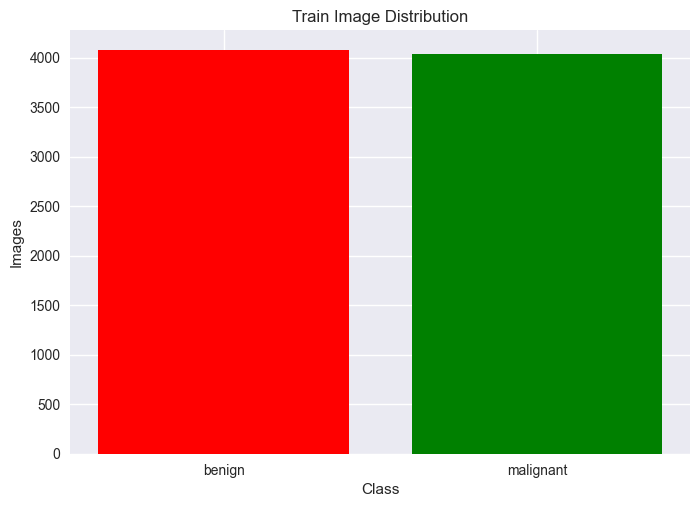

In [42]:
plot_distributions('train')

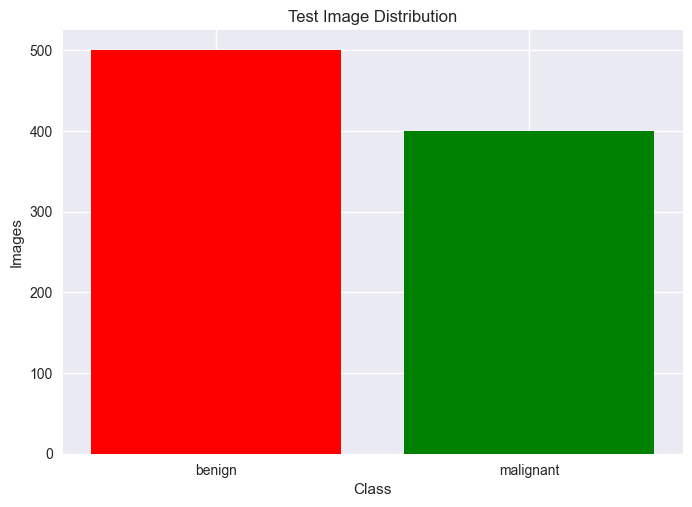

In [41]:
plot_distributions('test')

# Previewing Data

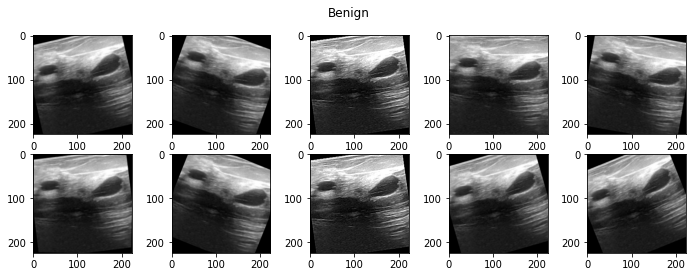

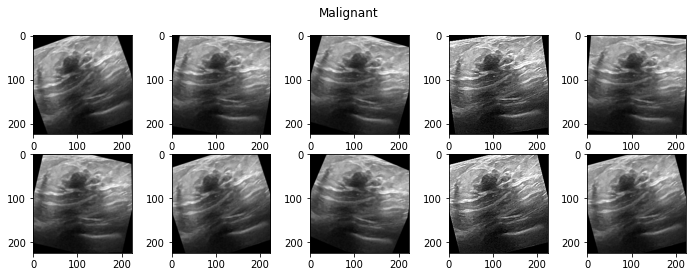

In [6]:
for x in classes:
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 4))
    images = os.listdir(os.path.join(train_dir, x, ''))
    samples = images[:10]
    for ax, sample in zip(axes.flat, samples):
        img = plt.imread(os.path.join(train_dir, x, sample))
        ax.imshow(img)
    fig.suptitle(x.capitalize())
    
plt.show()

In [45]:
# Viewing input shape
input_shape = plt.imread(
    os.path.join(
        os.path.join(train_dir, 'malignant', ''), 
        os.listdir(os.path.join(train_dir, 'malignant', ''))[0]
        )
    ).shape

input_shape

(224, 224, 3)

# Data Preprocessing

In [8]:
batch_size=32

# Augment new data
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=30,
    fill_mode='nearest',
    horizontal_flip=True,
    shear_range=0.2,
    rescale=1./255
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Creating data generators
train_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    target_size=(224, 224),
    class_mode='binary',
    classes=classes,
    shuffle=True,
)

valid_gen = valid_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=batch_size,
    target_size=(224, 224),
    class_mode='binary',
    classes=classes,
    shuffle=False
)

Found 8116 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


In [9]:
train_gen.class_indices

{'benign': 0, 'malignant': 1}

# Create and Train Model with InceptionV3 Architecture

InceptionV3 is a convolutional neural network (CNN) architecture developed by Google for image classification and object detection. It is a version of the popular Inception architecture that is trained on the ImageNet dataset, which is the state-of-the-art dataset that famous pretrained CNNs are trained on. The ImageNet dataset has 1.4 million images with 1000 classes, making it a really good dataset to train large models on that can be used in transfer learning. InceptionV3 achieved state-of-the-art performance on the ImageNet classification task.

Using the Keras Functional API, we incorporate the convolutional layers from the InceptionV3 architecture, freeze these layers, create our own dense/output layers, and then combine these steps to create our model that we will train onto our data set.

In [46]:
# Load in base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze transfer layers
for layer in base_model.layers:
    layer.trainable = False

# Create dense layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = GaussianNoise(0.1)(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = GaussianNoise(0.1)(x)
x = Dropout(0.25)(x)

# Output layer
output_layer = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

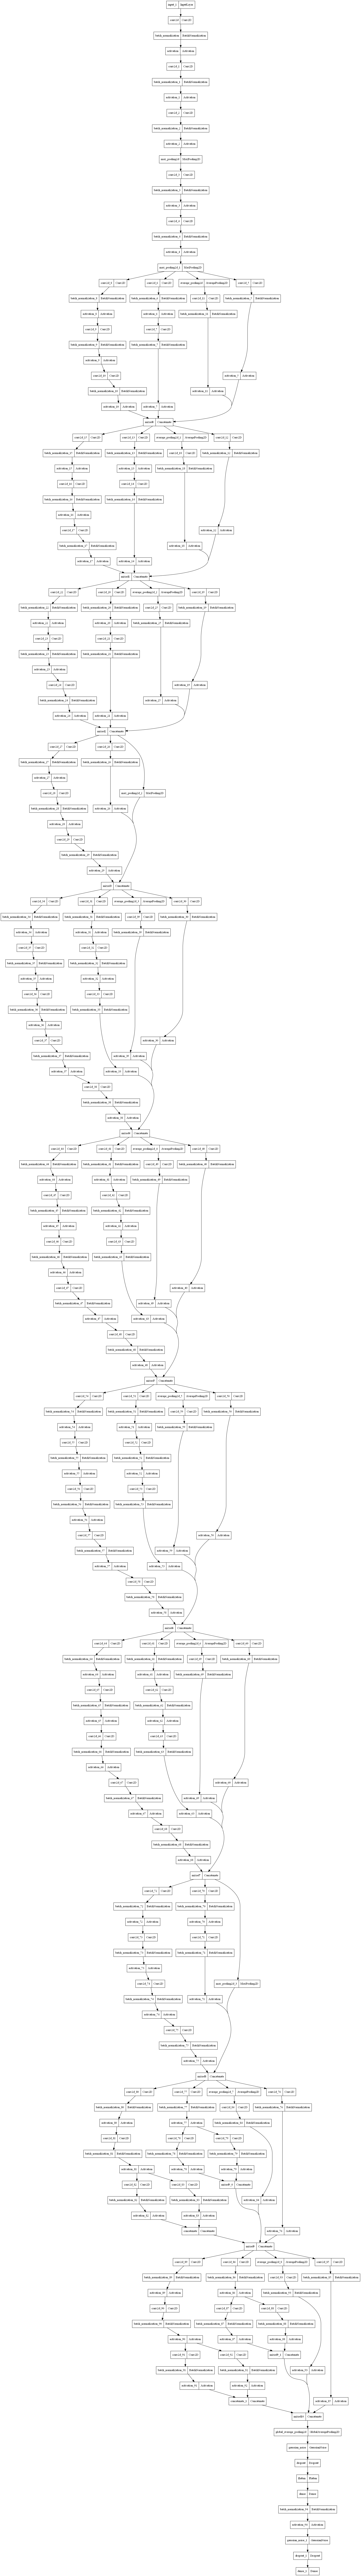

In [48]:
# visualize model
plot_model(model)

In [13]:
# Define fitting hyperparameters
steps_per_epoch = train_gen.samples // batch_size
valid_steps = valid_gen.samples // batch_size
callback = EarlyStopping(patience=10, mode='min', restore_best_weights=True)

In [229]:
# Train our model on our training and validation generators
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=valid_steps,
    epochs=50,
    callbacks=[callback]
)

Epoch 1/50
253/253 [==============================] - 387s 2s/step - loss: 0.5172 - accuracy: 0.7404 - val_loss: 0.4363 - val_accuracy: 0.7857
Epoch 2/50
253/253 [==============================] - 418s 2s/step - loss: 0.4481 - accuracy: 0.7869 - val_loss: 0.2994 - val_accuracy: 0.8806
Epoch 3/50
253/253 [==============================] - 411s 2s/step - loss: 0.4227 - accuracy: 0.8047 - val_loss: 0.3204 - val_accuracy: 0.8650
Epoch 4/50
253/253 [==============================] - 410s 2s/step - loss: 0.4102 - accuracy: 0.8125 - val_loss: 0.3413 - val_accuracy: 0.8482
Epoch 5/50
253/253 [==============================] - 410s 2s/step - loss: 0.3997 - accuracy: 0.8152 - val_loss: 0.3160 - val_accuracy: 0.8638
Epoch 6/50
253/253 [==============================] - 419s 2s/step - loss: 0.3915 - accuracy: 0.8184 - val_loss: 0.3136 - val_accuracy: 0.8638
Epoch 7/50
253/253 [==============================] - 415s 2s/step - loss: 0.3944 - accuracy: 0.8162 - val_loss: 0.2912 - val_accuracy: 0.8661

In [230]:
# Save model
model.save('ultrasound_model.h5')

# Save training history
with open('history.pickle', 'wb') as file:
    pickle.dump(history.history, file)

# Evaluate Model

In [49]:
model = load_model('ultrasound_model.h5')

with open('history.pickle', 'rb') as file:
    history = pickle.load(file)

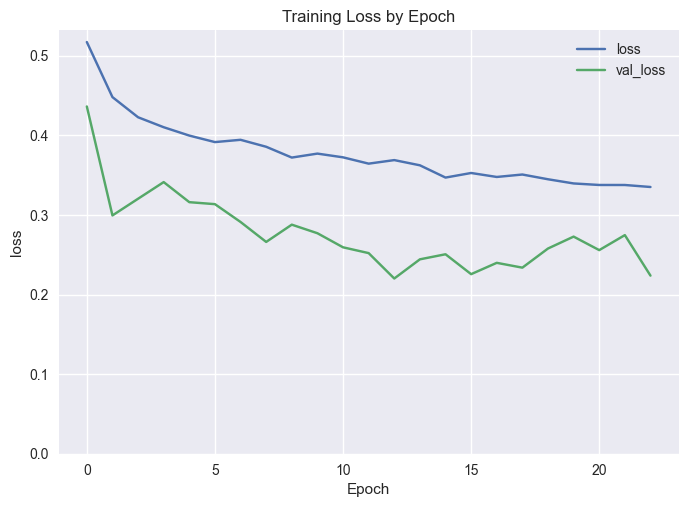

In [50]:
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Training Loss by Epoch')
plt.legend()
plt.show()

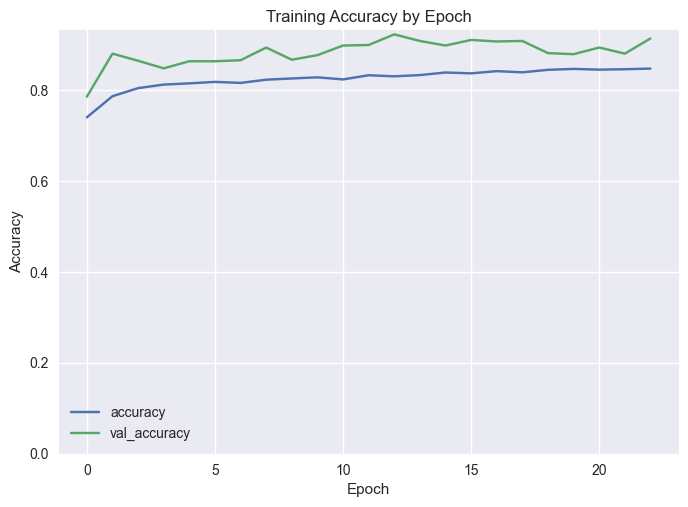

In [53]:
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy by Epoch')
plt.legend()
plt.show()

In [232]:
model.evaluate(train_gen)

254/254 [==============================] - 302s 1s/step - loss: 0.2867 - accuracy: 0.8754


[0.2867166996002197, 0.87543123960495]

In [234]:
model.evaluate(valid_gen)

29/29 [==============================] - 26s 904ms/step - loss: 0.2212 - accuracy: 0.9233


[0.22118084132671356, 0.9233333468437195]

Our model had a **87.5%** to our training data and a **92.3%** accuracy to our validation data. Now we are going to pull an image that is malignant to predict using our model.

# Predict Image

In [414]:
valid_gen.class_indices

{'benign': 0, 'malignant': 1}

1/1 [==============================] - 1s 915ms/step
TYPE: MALIGNANT


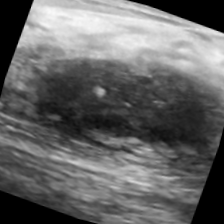

In [16]:
path = os.path.join(test_dir, 'malignant')
png = os.listdir(path)[0]
image = os.path.join(path, png)

def predict_img(image):
    img = load_img(image, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.

    predictions = model.predict(x).round()
    if predictions[0][0] == 1:
        y = 'MALIGNANT'
    else:
        y = 'BENIGN'
        
    print(f'TYPE: {y}')
    return img


predict_img(image)